#### IMPORT LIBRARIES

In [1]:
import numpy as np
import h5py as h5

import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable


import matplotlib.pyplot as plt
from importlib import reload, import_module

import glob
import os

import pdb
from PIL import Image as im
import _pickle as pickle
import cv2

from functions import processLF, get_variable, get_numpy, psnr_1

#### DATASET PATH

In [2]:
if os.name == 'nt':
    dataset_file = r"C:\Users\mummu\Documents\Datasets\srinivasan\trainset\h5\8bit.h5"
    test_file    = r"C:\Users\mummu\Documents\Datasets\srinivasan\testset\h5\8bit.h5"
    model_file   = r"model\model.pt"
    network_file = r"network"
    img_dir      = r"C:\Users\mummu\Documents\Datasets\kalantari\testset\EXTRA"
    img_paper    = r"C:\Users\mummu\Documents\Datasets\kalantari\testset\PAPER"
    
elif os.name == 'posix':
    raise NotImplementedError

#### BASIC PARAMETERS

In [3]:
minibatch_size = 1
gamma_val      = 0.4
lfsize         = [372, 540, 7, 7]
batch_affine   = True

In [4]:
trans = transforms.ToTensor()
p = np.ndarray([1])
q = np.ndarray([1])

In [5]:
network_module = import_module(network_file)
reload(network_module)

Net = network_module.Net

net = Net((lfsize[0], lfsize[1]), minibatch_size, lfsize, batchAffine=batch_affine)
#net.eval()

if torch.cuda.is_available():
    print('##converting network to cuda-enabled')
    net.cuda()

try:
    checkpoint = torch.load(model_file)
    
    net.load_state_dict(checkpoint['model'].state_dict())    
    print('Model successfully loaded.')
    
except:
    print('No model.')

##converting network to cuda-enabled
Model successfully loaded.


In [6]:
# To delete
#result = im.fromarray((get_numpy(corn[0,:3].permute(1,2,0)+1)/2 * 255).astype(np.uint8));result.save('corner1_f.png');
#result = im.fromarray((get_numpy(corn[0,3:6].permute(1,2,0)+1)/2 * 255).astype(np.uint8));result.save('corner2_f.png');
#result = im.fromarray((get_numpy(corn[0,6:9].permute(1,2,0)+1)/2 * 255).astype(np.uint8));result.save('corner3_f.png');
#result = im.fromarray((get_numpy(corn[0,9:].permute(1,2,0)+1)/2 * 255).astype(np.uint8));result.save('corner4_f.png');

In [7]:
def single_run(index, img_path = img_paper, img_name = 'Seahorse.png'):
            
    img = cv2.imread(os.path.join(img_path, img_name))
                    
    img = processLF(trans(img), lfsize, gamma_val)
    
    T = img[:, :, index[0], index[1], :].squeeze()
    corn = img[:, :, [0, -1, 0, -1], [0, 0, -1, -1], :].squeeze()
    
    Y, R, d = synthesizeView(corn, index)

    return T, Y, d

In [8]:
def synthesizeView(corn, index):
                
    p[0] = (index[0] - lfsize[2]//2)/(lfsize[2]//2)
    q[0] = (index[1] - lfsize[3]//2)/(lfsize[3]//2)
    
    corn = corn.permute(2,3,0,1).reshape(12,corn.shape[0],corn.shape[1])[None,:]

    with torch.no_grad():
        Y, R, d = net(get_variable(corn), get_variable(torch.from_numpy(p)), get_variable(torch.from_numpy(q)))
        
    return Y[0].permute(1,2,0), R[0].permute(1,2,0), d

C:\Users\mummu\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


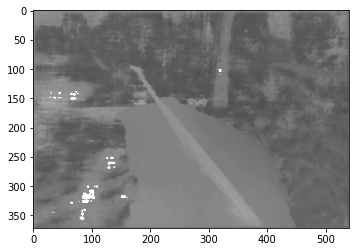

In [9]:
Y,R,d = single_run([3,3], img_name = 'Rock.png')
plt.imshow(get_numpy(d[0,0]+4)/8, cmap = 'gray', vmin = 0, vmax = 1.0);

In [19]:
# Run for all examples in the folder and every perspectives
def run_all_examples(img_path):
        
    files = [file for file in os.listdir(img_path) if file.endswith(".png")]
    ps = np.ndarray((len(files),7,7))

    for fi in range(len(files)):

        file = files[fi]

        print("Current file {}: {}" .format(fi,file))

        img = cv2.imread(os.path.join(img_path, file))
        img = processLF(trans(img), lfsize, gamma_val)

        corn = img[:, :, [0, -1, 0, -1], [0, 0, -1, -1], :].squeeze()

        for i in range(7):
            for j in range(7):

                T = get_numpy(img[:, :, i, j, :])
                Y,R,d = synthesizeView(corn, [i, j])
                Y = get_numpy(Y)

                ps[fi,i,j] = psnr_1(T, Y)
        
        psnr_excl_corners = ps[fi].reshape(-1)[[i for i in range(49) if (i-np.array((0,6,42,48))).all()]].mean()
        
        print("Current PSNR: {}" .format(psnr_excl_corners))
    
    return ps
                
    

In [20]:
ps = run_all_examples(img_paper)

Current file 0: Cars.png
Current PSNR: 34.79767170658
Current file 1: Flower1.png
Current PSNR: 33.0446169024824
Current file 2: Flower2.png
Current PSNR: 33.59390006293035
Current file 3: Rock.png
Current PSNR: 35.965820457223955
Current file 4: Seahorse.png
Current PSNR: 34.18418473366234


In [30]:
np.set_printoptions(precision = 2)
ps[3]

array([[38.22, 36.24, 35.85, 35.91, 35.98, 36.43, 39.05],
       [36.37, 35.85, 35.63, 35.72, 35.76, 36.03, 37.01],
       [35.77, 35.47, 35.36, 35.42, 35.55, 35.76, 36.35],
       [35.64, 35.37, 35.29, 35.4 , 35.55, 35.81, 36.31],
       [35.87, 35.53, 35.41, 35.51, 35.71, 36.01, 36.61],
       [36.67, 36.02, 35.79, 35.84, 36.03, 36.39, 37.36],
       [38.5 , 36.48, 36.14, 36.15, 36.29, 36.82, 38.89]])

34.31723877257581

In [18]:
# np.set_printoptions(precision=2)
# print(ps)

#for index, val in enumerate(list)
files = [file for file in os.listdir(img_dir) if file.endswith(".png")]

In [19]:
#for _, fi in enumerate(files):
ps.reshape(len(files),-1)[:,[i for i in range(49) if (i-np.array((0,6,42,48))).all()]].mean()

36.37107159891023